In [5]:
import numpy as np
import ast 
import pandas as pd
"""
• Write a function that checks one document (i.e. a biography) for
the following:
(a) the number of spans (i.e. token(s)) where both packages agree and predict is an NE (i.e. complete overlap in span predicted).
(b) the number of spans where there is a partial agreement between both packages (i.e. partial overlap in spans predicted).
(c) for each package, the number of spans that a package predicted as an NE, but the other package did not predict as an NE.
(d) for the spans with full and partial agreement, was there an agreement in the NE type (e.g. Person, Location, Organisation etc)
(e) Use visualisation to compare the above statistics, per category per package (i.e. Spacy vs Stanza)
"""

def complete_overlap(df_docrow):
    """
    (a) the number of spans (i.e. token(s)) where both packages agree and predict is an NE (i.e. complete overlap in span predicted)
    """
    ents_stanza = [ df_docrow['ents_stanza'][x][0] for x in range(len(df_docrow['ents_stanza']))]
    ents_spacy = [ df_docrow['ents_spacy'][x][0] for x in range(len(df_docrow['ents_spacy']))]
    ents_both = [ent for ent in ents_stanza if ent in ents_spacy]
    return ents_both

def partial_overlap(df_docrow):
    """
    (b) the number of spans where there is a partial agreement between both packages (i.e. partial overlap in spans predicted).   
    PARTIAL strictly (perfect matches are removed)
    """
    ents_stanza = [ df_docrow['ents_stanza'][x][0] for x in range(len(df_docrow['ents_stanza']))]
    ents_spacy = [ df_docrow['ents_spacy'][x][0] for x in range(len(df_docrow['ents_spacy']))]
    complete = complete_overlap(df_docrow)
    ents_both_partial = [ent for ent in ents_stanza if ent in " ".join(ents_spacy) and ent not in complete]
    ents_both_partial.extend([ent for ent in ents_spacy if ent in " ".join(ents_stanza) and ent not in ents_both_partial and ent not in complete])
    #print(ents_both_partial)
    return ents_both_partial

def one_but_not_the_other(df_docrow):
    """
    (c) for each package, the number of spans that a package predicted as an NE, but the other package did not predict as an NE.
    """
    ents_stanza = [ df_docrow['ents_stanza'][x][0] for x in range(len(df_docrow['ents_stanza']))]
    ents_spacy = [ df_docrow['ents_spacy'][x][0] for x in range(len(df_docrow['ents_spacy']))]
    elts_both_lists = complete_overlap(df_docrow) #elements that are in both lists (complete element)
    elts_both_lists_partial = partial_overlap(df_docrow)
    merged_lists = ents_stanza
    merged_lists.extend(ents_spacy)
    only_in_one_complete= [ent for ent in merged_lists if ent not in elts_both_lists] # yields the elements in `merged_lists` that are NOT in `elts_both_lists`
    only_in_one_partial = [
        ent for ent in only_in_one_complete 
        if not any(ent in partial_str for partial_str in elts_both_lists_partial)
        and not any (partial_str in ent for partial_str in elts_both_lists_partial)
    ]
    return only_in_one_complete, only_in_one_partial

def find_tuple_with_first_value(tuples_list, specific_value):
    """Returns the tuple with the specific_value as the first element if found, else None."""
    for tup in tuples_list:
        #print('f', tup, specific_value)
        if tup[0] == specific_value:
            return tup
    return None

def find_tuple_containing_value(tuples_list, specific_value):
    """Returns the tuple when the specidied value is included in the named entity predicted, else None."""
    for tup in tuples_list:
        #print('c', tup, specific_value)
        if specific_value in tup[0] :
            return tup
    return None

def agreement_ne_type_complete(df_docrow):
    """
    (d) for the spans with full agreement, was there an agreement in the NE type (e.g. Person, Location, Organisation etc)
    """
    spans_agreement = complete_overlap(df_docrow)

    row_span_spacy = [ df_docrow['ents_stanza'][x] for x in range(len(df_docrow['ents_stanza']))]
    row_span_stanza = [ df_docrow['ents_spacy'][x] for x in range(len(df_docrow['ents_spacy']))]
    agree = 0
    disagree = 0
    for span in spans_agreement:
        if(find_tuple_with_first_value(row_span_spacy, span)[1] == find_tuple_with_first_value(row_span_stanza, span)[1]):
            agree +=1
        else:
            disagree +=1
    
        
    return agree, disagree

def agreement_ne_type_partial(df_docrow):
    """
    (d) for the spans with partial agreement, was there an agreement in the NE type (e.g. Person, Location, Organisation etc)
    """
    spans_agreement = partial_overlap(df_docrow)

    row_span_spacy = [ df_docrow['ents_stanza'][x] for x in range(len(df_docrow['ents_stanza']))]
    row_span_stanza = [ df_docrow['ents_spacy'][x] for x in range(len(df_docrow['ents_spacy']))]
    agree = 0
    disagree = 0
    for span in spans_agreement:
            if(find_tuple_with_first_value(row_span_spacy, span) != None 
            and find_tuple_containing_value(row_span_stanza, span) != None
            and find_tuple_with_first_value(row_span_spacy, span)[1] == find_tuple_containing_value(row_span_stanza, span)[1]):
                agree +=1
            elif(find_tuple_with_first_value(row_span_stanza, span) != None 
            and find_tuple_containing_value(row_span_spacy, span) != None
            and find_tuple_with_first_value(row_span_stanza, span)[1] == find_tuple_containing_value(row_span_spacy, span)[1]):
                agree +=1
            else:
                disagree +=1
        
    return agree, disagree
    

In [6]:
def comparison_stanza_spacy_printout(pd_df, doc):
    """
    Print out all the comparisons between stanza and spacy
    """
    print(doc)
    row_doc = pd_df.loc[pd_df['file_name'] == doc]
    #print(row_doc)
    row_doc = row_doc.iloc[0]
    #print(row_doc)
    print(f"Number of spans where both packages agree and predict is a NE : {len(complete_overlap(row_doc))}")
    print('\n\n')
    print(f"Number of spans where there is a partial agreement between both packages: {len(partial_overlap(row_doc))}")
    print('\n\n')
    complete_one, partial_one = one_but_not_the_other(row_doc)
    print(f"Number of spans that a package predicted as an NE, but the other package did not predict as a NE (only exact matches): {len(complete_one)}")
    print(f"Number of spans that a package predicted as an NE, but the other package did not predict as a NE (with partial matches): {len(partial_one)}")
    total_agree, total_disagree = agreement_ne_type_complete(row_doc)
    partial_agree, partial_disagree = agreement_ne_type_partial(row_doc)
    print("\n\nTotal agreement for NE: ")
    print(f"Number of span agreeing on the NE type : {total_agree}")
    print(f"Number of span disagreeing on the NE type : {total_disagree}")
    print("\nPartial agreement for NE: ")
    print(f"Number of span agreeing on the NE type : {partial_agree}")
    print(f"Number of span disagreeing on the NE type : {partial_disagree}")


def comparison_stanza_spacy(pd_df, doc):
    """
    Return all the comparison figures between stanza and spacy to allow for further processing (such as plotting)
    """
    row_doc = pd_df.loc[pd_df['file_name'] == doc]
    #print(row_doc)
    row_doc = row_doc.iloc[0]
    try:
        complete_overlap_result = complete_overlap(row_doc)
        partial_overlap_result = partial_overlap(row_doc)
        complete_one, partial_one = one_but_not_the_other(row_doc)
        total_agree, total_disagree = agreement_ne_type_complete(row_doc)
        partial_agree, partial_disagree = agreement_ne_type_partial(row_doc)
        result = {
            'file_name': doc,
            'both_NE': len(complete_overlap_result),
            'both_partial_NE': len(partial_overlap_result),
            'complete_one': len(complete_one),
            'partial_one': len(partial_one),
            'total_agree': total_agree,
            'total_disagree': total_disagree,
            'partial_agree': partial_agree,
            'partial_disagree': partial_disagree
        }
        return result
    except ValueError as e:
        print(f"Error: {e}")
        return None
                        
def all_values_per_category(df):
    """
    Loops through all named entities predictions contained in the dataframe for a category to get the numbers 
    for comparison between stanza and spacy for all instances of a category, stored in a dataframe
    """
    results = []
    for _, row in df.iterrows():
        file_name = row['file_name']
        result = comparison_stanza_spacy(df, file_name)
        if result:
            results.append(result)
    
    df_values = pd.DataFrame(results)
    return df_values
    


In [7]:
import matplotlib.pyplot as plt

def plot_mean_comparison(dataframes, cat):
    """
    (e) Use visualisation to compare the above statistics, per category per package (i.e. Spacy vs Stanza)
    plot the mean for each column across several dataframes (here for Journalists and Sculptors)
    
    :param dataframes: List of DataFrames generated by mean_all_values
    :param act: List of categories for each DataFrame
    """
    means = []

    for df in dataframes:
        df = df.rename(columns={'both_NE': 'predicted as NE by both library', 'both_partial_NE': 'partially predicted as NE by both library', 'complete_one': 'predicted as NE by one but not the other (total overlap)', 'partial_one': 'predicted as NE by one but not the other (partial overalp)',
                           'total_agree': 'agreement for the NE type on total overlap', 'total_disagree': 'disagreement for the NE type on total overlap', 'partial_agree': 'agreement for the NE type on partial overlap', 'partial_disagree': 'disagreement for the NE type on partial overlap'})
        means.append(df.drop(columns=['file_name']).mean())
    
    means_df = pd.DataFrame(means, index=cat)
    
    # Plotting the means
    ax = means_df.plot(kind='bar', figsize=(12, 8))
    
    ax.set_ylabel('Mean Values')
    ax.set_title('Comparison of Mean Values Across Categories')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Comparison of stanza and spacy NE recognition by category')
    plt.tight_layout()
    plt.show()


In [8]:
df_journalists = pd.read_pickle('ents_journalists.pkl')
df_sculptors = pd.read_pickle('ents_sculptors.pkl')


In [9]:
#example output with str output with one of the journalists file

comparison_stanza_spacy_printout(df_journalists, 'Biographies_Journalists\\AlbertM.Chop_Journalists.txt')

Biographies_Journalists\AlbertM.Chop_Journalists.txt
Number of spans where both packages agree and predict is a NE : 44



Number of spans where there is a partial agreement between both packages: 7



Number of spans that a package predicted as an NE, but the other package did not predict as a NE (only exact matches): 22
Number of spans that a package predicted as an NE, but the other package did not predict as a NE (with partial matches): 8


Total agreement for NE: 
Number of span agreeing on the NE type : 34
Number of span disagreeing on the NE type : 10

Partial agreement for NE: 
Number of span agreeing on the NE type : 4
Number of span disagreeing on the NE type : 3


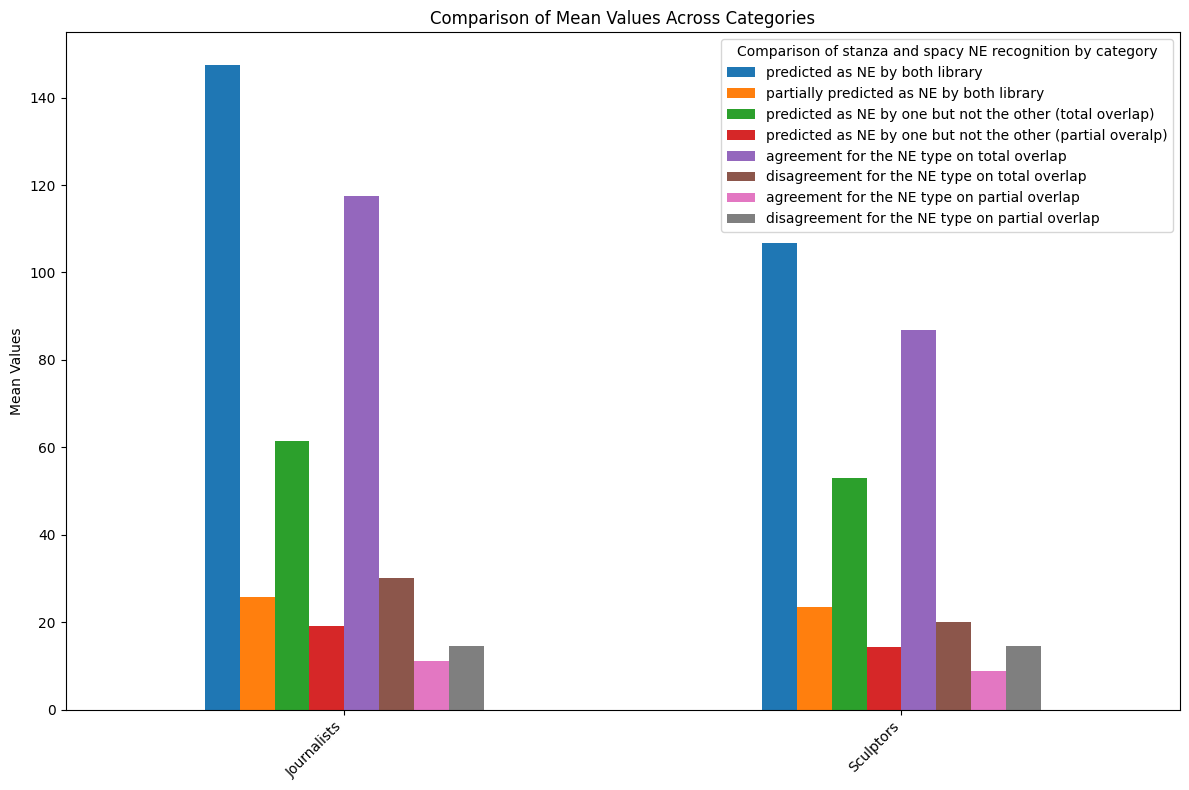

In [10]:
#Comparison of the two package on both categories
plot_mean_comparison([all_values_per_category(df_journalists), all_values_per_category(df_sculptors)], ['Journalists','Sculptors'])

In [11]:
#example output for one entire dataframe
all_values_per_category(df_journalists).head()

,file_name,both_NE,both_partial_NE,complete_one,partial_one,total_agree,total_disagree,partial_agree,partial_disagree
0,Biographies_Journalists\31Minutos_Journalists.txt,493,92,237,65,421,72,33,59
1,Biographies_Journalists\AbdelkaderBensalah_Jou...,64,9,18,1,54,10,6,3
2,Biographies_Journalists\AlbertM.Chop_Journalis...,44,7,22,8,34,10,4,3
3,Biographies_Journalists\AlbertoCañasEscalante_...,149,27,71,24,110,39,15,12
4,Biographies_Journalists\AlexanderGelman(writer...,199,39,150,90,185,14,12,27
